In [22]:
import sys
import os

# Add src to the system path to allow imports from the src directory
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../../..', 'src'))
sys.path.insert(0, src_path)

In [23]:
from dolfin import *
import ufl
from materials import *
from params import *
from matplotlib import pyplot as plt
%matplotlib inline

## Initialize problem

In [24]:
params = Params()
params.print_table()

| Parameter    |        Value | Unit   |
|--------------|--------------|--------|
| dimension    |      3       | -      |
| plane_stress |      0       | Bool   |
| Lx           |    500       | m      |
| Ly           |    750       | m      |
| Lz           |    125       | m      |
| g            |      9.81    | m/s²   |
| rho_sea      |  10006.2     | N/m³   |
| E0_ice       |      9.5e+09 | Pa     |
| nu_ice       |      0.35    | -      |
| rho_i_ice    |   8995.77    | N/m³   |
| sigma_c_ice  | 474000       | Pa     |
| ci           |      1       | -      |


In [25]:
g = params.g
rho_sea = params.rho_sea
E0_ice = params.E0_ice
nu_ice = params.nu_ice
rho_i_ice = params.rho_i_ice
sigma_c_ice = params.sigma_c_ice

In [26]:
xdmf = XDMFFile("output/static/no_crevasse_2D.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = False
xdmf.parameters["flush_output"] = True

## Initialize Mesh

In [27]:
Lx, Ly, Lz = params.Lx, params.Ly, params.Lz
mesh = RectangleMesh(Point(0, 0), Point(Lx, Lz), Lx, Lz)

## Initialize material model

In [28]:
ice = LinearElastic(mesh, params)

# Initialize boundary conditions

In [29]:
FDG0 = FunctionSpace(mesh, "DG", 0)
TDG0 = TensorFunctionSpace(mesh, "DG", 0)
V1 = VectorFunctionSpace(mesh, "CG", 1)

In [30]:
support_left = CompiledSubDomain("on_boundary && near(x[0], 0.0, tol)", tol=1e-14)
support_bottom = CompiledSubDomain("on_boundary && near(x[1],0.0, tol)", tol=1e-14)
load_right = CompiledSubDomain("on_boundary && x[1]<= 62.5 && x[0]==500")

mf_line = MeshFunction("size_t", mesh, 1)
load_right.mark(mf_line, 1)

ds = Measure("ds")(subdomain_data=mf_line)

In [31]:
bc_sp_x = DirichletBC(V1.sub(0), Constant(0.0), support_left)
bc_sp_x2 = DirichletBC(V1.sub(1), Constant(0.0), support_bottom)
bc_u = [bc_sp_x, bc_sp_x2]

## Setup and Solve Problem

In [32]:
u, v = TrialFunction(V1), TestFunction(V1)
u_sol = Function(V1, name="disp")
stress_xx, cdf = Function(FDG0, name="sigma_xx"), Function(FDG0, name="cdf")

In [33]:
# t = Expression(("-(rho_sea*(125/2 -x[1]))", 0), rho_sea=rho_sea, degree=1)

t = Constant((0, 0))
f = Constant((0, -ice.rho))

In [34]:
a = inner(ice.stress(u), ice.strain(v))* Ly * dx
L = dot(f, v) * Ly * dx + dot(t, v) * Ly * ds(1)

In [35]:
solve(a == L, u_sol, bc_u)

Solving linear variational problem.


## Post Processing

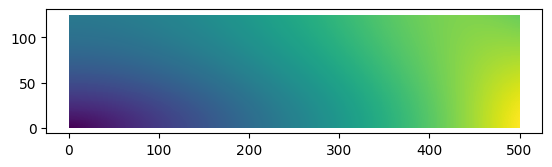

In [36]:
plot(u_sol, mode='displacement')

In [37]:
stress_xx.assign(project(ice.stress(u_sol)[0,0]/1e6, FDG0)) # N/m2 -> MPa
cdf.assign(project(ice.get_crack_driving_force(u_sol), FDG0))

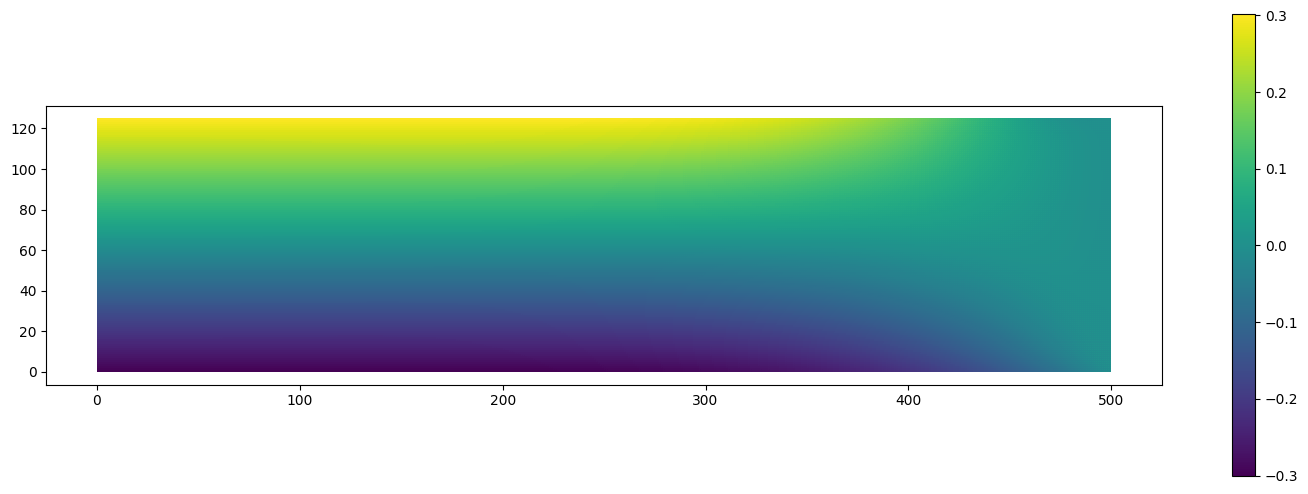

In [38]:
plt.figure(figsize=(18, 6))
c = plot(stress_xx)
plt.colorbar(c)  # Adds the colorbar
plt.show()

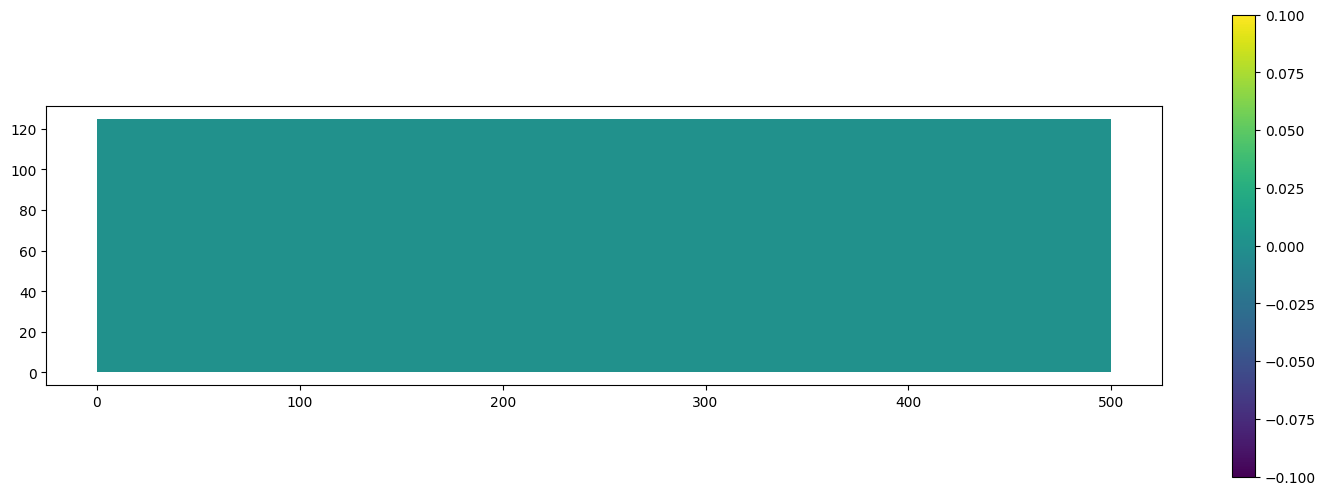

In [39]:
plt.figure(figsize=(18, 6))
c = plot(cdf)
plt.colorbar(c)  # Adds the colorbar
plt.show()

In [40]:
xdmf.write(u_sol,0)
xdmf.write(stress_xx,0)
xdmf.write(cdf,0)
xdmf.close()

In [41]:
cdf.vector().max()

0.0

In [42]:
stress_xx.vector().max()

0.30181139813396984